In [1]:
import pandas as pd
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm

import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from shapely.geometry import Polygon, MultiPolygon
from pyresample import geometry, load_area

In [2]:
mydir = "/home/ingrid/Documents/Exjobb/rain_gauge_data/csv_formatado/"
filename_list = os.listdir(mydir)
print(len(filename_list))

609


In [3]:
def extractLonLat(filename):
    lonlat = filename.split("W")[1][:-4].split("_S")
    lon = -float(lonlat[0])
    lat = -float(lonlat[1])
    return(lon, lat)

In [4]:
lons = []
lats = []
for filename in filename_list:
    lon, lat = extractLonLat(filename)
    lons.append(lon)
    lats.append(lat)

In [5]:
d = {'lon': lons, 'lat': lats}
lonlats_df = pd.DataFrame(data=d)

In [6]:
print(lonlats_df)

           lon        lat
0   -56.437222 -30.368611
1   -46.027500  -7.455278
2   -45.372778  -1.661667
3   -57.526667 -11.280278
4   -43.864722  -8.443056
..         ...        ...
604 -43.184167 -13.416667
605 -41.106944 -20.104167
606 -50.425278 -16.945833
607 -49.274167  -8.259167
608 -54.381111 -15.580000

[609 rows x 2 columns]


In [7]:
lonlats_df.to_pickle('../reference/rain_gauge_locs.pckl')

In [7]:
filename = filename_list[0]
lon, lat = extractLonLat(filename)
print(lon, lat)

-56.43722221 -30.3686111


In [8]:
df = pd.read_csv(mydir+filename_list[0], delimiter = ',', header=0)
print(df.tail()) 

        DATA_UTC   00   01   02   03   04   05   06   07   08  ...   14   15  \
4820  2020-12-27  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4821  2020-12-28  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4822  2020-12-29  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4823  2020-12-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4824  2020-12-31  0.0  0.4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

       16   17   18   19   20   21   22   23  
4820  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4821  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4822  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4823  0.0  0.0  0.0  2.6  0.2  0.0  0.8  1.2  
4824  0.0  NaN  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 25 columns]


In [9]:
df.DATA_UTC = pd.to_datetime(df.DATA_UTC, format='%Y-%m-%d')

In [10]:
mask = (df.DATA_UTC >= '2020-3-1')

In [11]:
df.loc[mask]

,DATA_UTC,00,01,02,03,04,05,06,07,08,...,14,15,16,17,18,19,20,21,22,23
4519,2020-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4520,2020-03-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4521,2020-03-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4522,2020-03-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4523,2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4820,2020-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4821,2020-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4822,2020-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4823,2020-12-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.6,0.2,0.0,0.8,1.2


/home/ingrid/anaconda3/envs/geostat/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/ingrid/anaconda3/envs/geostat/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


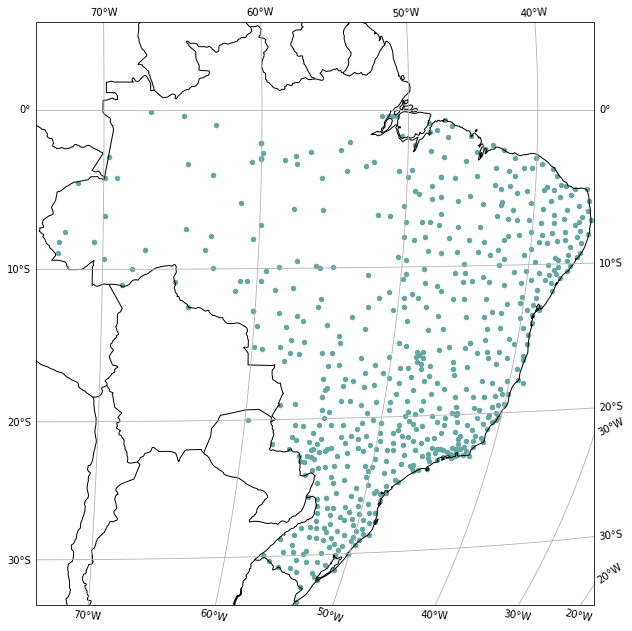

In [27]:
import sys
sys.path.append('../visualize')
import plot_dataset_funs
from plot_dataset_funs import initial_load

areas_filepath =  '../dataset/downloads/files/areas.yaml'
initial_load(areas_filepath)
area_def_region = plot_dataset_funs.area_def.copy(area_extent = plot_dataset_funs.region_corners,
                                                  height = plot_dataset_funs.region_height, 
                                                  width = plot_dataset_funs.region_width)
crs = area_def_region.to_cartopy_crs()
fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize = (10,11))

ax.scatter(x=lonlats_df.lon, y=lonlats_df.lat, transform=ccrs.PlateCarree(), s=20, color='#64a6a1')

ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.BORDERS)
ax.set_global()
#ax.title.set_text(plot_title)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

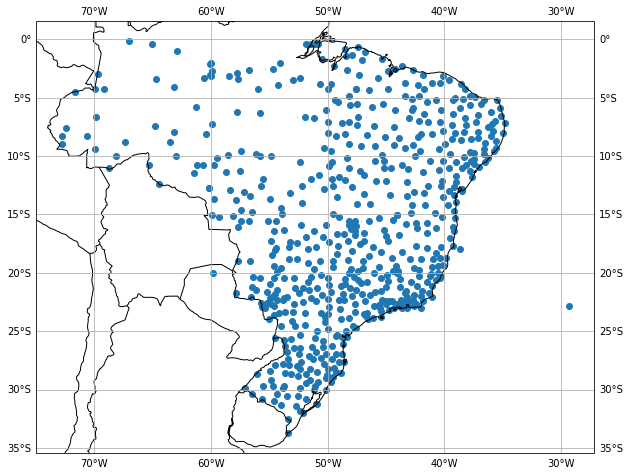

In [16]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize = (10,11))
ax.scatter(x=lonlats_df.lon, y=lonlats_df.lat,  transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.BORDERS)

In [32]:
hej = np.array([1, 4, 5])
x = np.where(hej == 4)
print(hej[x])

[4]
